In [ ]:
import pandas as pd
import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt
from pathlib import Path
import os

from sklearn.metrics import classification_report
import tensorflow.keras.backend as K

from tensorflow.keras import layers

E0000 00:00:1753431396.138184      10 common_lib.cc:612] Could not set metric server port: INVALID_ARGUMENT: Could not find SliceBuilder port 8471 in any of the 0 ports provided in `tpu_process_addresses`="local"
=== Source Location Trace: === 
learning/45eac/tfrc/runtime/common_lib.cc:230


In [ ]:
# Config 
INPUT_DIR = Path("/kaggle/working/output_wav2vec_custom_augmented")
OUTPUT_DIR = Path("./output_confmr2_class_tpu")
OUTPUT_DIR.mkdir(exist_ok=True)

MAX_SEQ_LEN = 150
EMBEDDING_DIM = 768
LABEL_COLS = ['Prolongation', 'Block', 'SoundRep', 'WordRep', 'Interjection']
NUM_CLASSES = len(LABEL_COLS)

BATCH_SIZE_PER_REPLICA = 16
EPOCHS = 400
LEARNING_RATE = 1e-6
THRESHOLD = 0.5

TRAIN_DATA_PATH = INPUT_DIR / "train_data.npz"
VAL_DATA_PATH = INPUT_DIR / "val_data.npz"
TEST_DATA_PATH = INPUT_DIR / "test_data.npz"
OUTPUT_DIR = Path("./")
BEST_MODEL_PATH = OUTPUT_DIR / "best_confmr2_model.keras"


In [ ]:
print("--- Initializing TPU Strategy ---")

try:
    tpu = tf.distribute.cluster_resolver.TPUClusterResolver.connect(tpu='local')
    # tf.config.experimental_connect_to_cluster(tpu)
    # tf.tpu.experimental.initialize_tpu_system(tpu)
    strategy = tf.distribute.TPUStrategy(tpu)
    
    print('TPU successfully initialized. Found TPU: ', tpu.master())
    BATCH_SIZE = BATCH_SIZE_PER_REPLICA * strategy.num_replicas_in_sync
    print(f"Global batch size set to: {BATCH_SIZE}")
    print("Number of replicas:", strategy.num_replicas_in_sync)

except Exception as e:
    print(f"TPU initialization failed, this is the error: {e}")
    print("Falling back to default strategy (CPU/GPU).")
    strategy = tf.distribute.get_strategy()
    BATCH_SIZE = BATCH_SIZE_PER_REPLICA


--- Initializing TPU Strategy ---
INFO:tensorflow:Deallocate tpu buffers before initializing tpu system.
INFO:tensorflow:Initializing the TPU system: local


I0000 00:00:1753431422.668929      10 service.cc:148] XLA service 0x5ba199fb3b90 initialized for platform TPU (this does not guarantee that XLA will be used). Devices:
I0000 00:00:1753431422.668976      10 service.cc:156]   StreamExecutor device (0): TPU, 2a886c8
I0000 00:00:1753431422.668981      10 service.cc:156]   StreamExecutor device (1): TPU, 2a886c8
I0000 00:00:1753431422.668984      10 service.cc:156]   StreamExecutor device (2): TPU, 2a886c8
I0000 00:00:1753431422.668987      10 service.cc:156]   StreamExecutor device (3): TPU, 2a886c8
I0000 00:00:1753431422.668990      10 service.cc:156]   StreamExecutor device (4): TPU, 2a886c8
I0000 00:00:1753431422.668993      10 service.cc:156]   StreamExecutor device (5): TPU, 2a886c8
I0000 00:00:1753431422.668995      10 service.cc:156]   StreamExecutor device (6): TPU, 2a886c8
I0000 00:00:1753431422.668998      10 service.cc:156]   StreamExecutor device (7): TPU, 2a886c8


INFO:tensorflow:Finished initializing TPU system.
INFO:tensorflow:Found TPU system:
INFO:tensorflow:*** Num TPU Cores: 8
INFO:tensorflow:*** Num TPU Workers: 1
INFO:tensorflow:*** Num TPU Cores Per Worker: 8
INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:localhost/replica:0/task:0/device:CPU:0, CPU, 0, 0)
INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:localhost/replica:0/task:0/device:TPU:0, TPU, 0, 0)
INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:localhost/replica:0/task:0/device:TPU:1, TPU, 0, 0)
INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:localhost/replica:0/task:0/device:TPU:2, TPU, 0, 0)
INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:localhost/replica:0/task:0/device:TPU:3, TPU, 0, 0)
INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:localhost/replica:0/task:0/device:TPU:4, TPU, 0, 0)
INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:localhost/replica:0/task:0/device:TPU:5, TPU, 0, 0)
I

In [ ]:
print("\nLoading all compressed features")

train_data = np.load(TRAIN_DATA_PATH)
val_data = np.load(VAL_DATA_PATH)
test_data = np.load(TEST_DATA_PATH)

# Access the arrays by the keys we used when saving ('x' and 'y')
X_train, y_train = train_data['x'], train_data['y']
X_val, y_val = val_data['x'], val_data['y']
X_test, y_test = test_data['x'], test_data['y']


print("All compressed data loaded successfully.")
print(f"X_train shape: {X_train.shape}")
print(f"y_train shape: {y_train.shape}")



Loading all compressed features
All compressed data loaded successfully.
X_train shape: (33945, 150, 768)
y_train shape: (33945, 6)


In [ ]:
# Remove the last column ('NoStutter') from the labels
y_train = y_train[:, :-1]
y_val = y_val[:, :-1]
y_test = y_test[:, :-1]

# Filter out samples that now have NO labels
train_indices = np.where(y_train.sum(axis=1) > 0)[0]
val_indices = np.where(y_val.sum(axis=1) > 0)[0]
test_indices = np.where(y_test.sum(axis=1) > 0)[0]

X_train, y_train = X_train[train_indices], y_train[train_indices]
X_val, y_val = X_val[val_indices], y_val[val_indices]
X_test, y_test = X_test[test_indices], y_test[test_indices]

print("Data loaded and modified successfully.")
print(f"New X_train shape: {X_train.shape}")


Data loaded and modified successfully.
New X_train shape: (29783, 150, 768)


In [ ]:
print("\n Verifying final training set distribution after augmentation")

final_train_labels_df = pd.DataFrame(y_train, columns=LABEL_COLS)

print("Final distribution of labels in the training set (including augmented samples):")
print(final_train_labels_df.sum().sort_values(ascending=False))



 Verifying final training set distribution after augmentation
Final distribution of labels in the training set (including augmented samples):
Block           10848
Interjection    10824
Prolongation    10800
SoundRep        10576
WordRep         10569
dtype: int64


In [ ]:
print("\nBuilding tf.data pipeline")

def prepare_dataset(X, y, shuffle=False):
    ds = tf.data.Dataset.from_tensor_slices((X, y))
    if shuffle:
        ds = ds.shuffle(buffer_size=2048)
    ds = ds.batch(BATCH_SIZE)
    ds = ds.prefetch(tf.data.AUTOTUNE)
    return ds

train_dataset = prepare_dataset(X_train, y_train, shuffle=True)
val_dataset = prepare_dataset(X_val, y_val)
test_dataset = prepare_dataset(X_test, y_test)
print("Datasets created successfully.")


Building tf.data pipeline
Datasets created successfully.


In [ ]:
with strategy.scope():
    print("\nBuilding Conformer Model")

    # Conformer Block
    def conformer_block(x, num_heads=4, ff_dim=128, dropout=0.1):
        # Convolution Module
        x_conv = layers.LayerNormalization()(x)
        x_conv = layers.Conv1D(filters=EMBEDDING_DIM * 2, kernel_size=1, activation="relu")(x_conv)
        x_conv = layers.DepthwiseConv1D(kernel_size=3, padding="same")(x_conv)
        x_conv = layers.BatchNormalization()(x_conv)
        x_conv = layers.Activation("swish")(x_conv)
        x_conv = layers.Conv1D(filters=EMBEDDING_DIM, kernel_size=1)(x_conv)
        x_conv = layers.Dropout(dropout)(x_conv)
        x = x + x_conv # Residual connection

        # Attention Module
        x_attn = layers.LayerNormalization()(x)
        x_attn = layers.MultiHeadAttention(num_heads=num_heads, key_dim=EMBEDDING_DIM // num_heads)(x_attn, x_attn)
        x_attn = layers.Dropout(dropout)(x_attn)
        x = x + x_attn # Residual connection

        # Feed Forward Module
        x_ff = layers.LayerNormalization()(x)
        x_ff = layers.Dense(ff_dim, activation="swish")(x_ff)
        x_ff = layers.Dropout(dropout)(x_ff)
        x_ff = layers.Dense(EMBEDDING_DIM)(x_ff)
        x = x + x_ff # Residual connection

        return x

    def build_conformer_classifier(input_shape, num_classes):
        inputs = layers.Input(shape=input_shape)
        x = inputs

        # Applies Conformer blocks
        x = conformer_block(x, num_heads=4, ff_dim=256)
        x = conformer_block(x, num_heads=4, ff_dim=256)

        # Pools the sequence to a single vector
        x = layers.GlobalAveragePooling1D()(x)

        # Classifier head
        x = layers.Dense(128, activation='relu')(x)
        x = layers.Dropout(0.5)(x)
        outputs = layers.Dense(num_classes, activation='sigmoid')(x)

        model = tf.keras.Model(inputs=inputs, outputs=outputs)

        optimizer = tf.keras.optimizers.Adam(learning_rate=LEARNING_RATE, clipnorm=1.0)
        
        model.compile(
            optimizer=optimizer,
            loss='binary_crossentropy',
            metrics=['accuracy', tf.keras.metrics.Precision(name='precision'), tf.keras.metrics.Recall(name='recall'), tf.keras.metrics.AUC(name='auc', multi_label=True)]
        )
        return model

    model = build_conformer_classifier(input_shape=(MAX_SEQ_LEN, EMBEDDING_DIM), num_classes=NUM_CLASSES)

model.summary()

checkpoint = tf.keras.callbacks.ModelCheckpoint(BEST_MODEL_PATH, monitor='val_auc', mode='max', save_best_only=True, verbose=1)
early_stopping = tf.keras.callbacks.EarlyStopping(monitor='val_auc', mode='max', patience=10, restore_best_weights=True)

print(f"LEARNING RATE: {LEARNING_RATE}")
print(f"BATCH SIZE: {BATCH_SIZE}")



Building Conformer Model


Model: "functional_2"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer_2       │ (None, 150, 768)  │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ layer_normalizatio… │ (None, 150, 768)  │      1,536 │ input_layer_2[0]… │
│ (LayerNormalizatio… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1d_8 (Conv1D)   │ (None, 150, 1536) │  1,181,184 │ layer_normalizat… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ depthwise_conv1d_4  │ (None, 150, 1536) │      6,144 │ conv1d_8[0][0]    │
│ (DepthwiseConv1D)   │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 150, 1536) │      6,144 │ depthwise_conv1d… │
│ (BatchNormalizatio… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ activation_4        │ (None, 150, 1536) │          0 │ batch_normalizat… │
│ (Activation)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1d_9 (Conv1D)   │ (None, 150, 768)  │  1,180,416 │ activation_4[0][… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout_18          │ (None, 150, 768)  │          0 │ conv1d_9[0][0]    │
│ (Dropout)           │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ add_12 (Add)        │ (None, 150, 768)  │          0 │ input_layer_2[0]… │
│                     │                   │            │ dropout_18[0][0]  │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ layer_normalizatio… │ (None, 150, 768)  │      1,536 │ add_12[0][0]      │
│ (LayerNormalizatio… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ multi_head_attenti… │ (None, 150, 768)  │  2,362,368 │ layer_normalizat… │
│ (MultiHeadAttentio… │                   │            │ layer_normalizat… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout_20          │ (None, 150, 768)  │          0 │ multi_head_atten… │
│ (Dropout)           │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ add_13 (Add)        │ (None, 150, 768)  │          0 │ add_12[0][0],     │
│                     │                   │            │ dropout_20[0][0]  │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ layer_normalizatio… │ (None, 150, 768)  │      1,536 │ add_13[0][0]      │
│ (LayerNormalizatio… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_12 (Dense)    │ (None, 150, 256)  │    196,864 │ layer_normalizat… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout_21          │ (None, 150, 256)  │          0 │ dense_12[0][0]    │
│ (Dropout)           │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_13 (Dense)    │ (None, 150, 768)  │    197,376 │ dropout_21[0][0]  │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ add_14 (Add)        │ (None, 150, 768)  │          0 │ add_13[0][0],     │
│                     │                   │            │ dense_13[0][0]  

 Total params: 10,369,285 (39.56 MB)

 Trainable params: 10,363,141 (39.53 MB)

 Non-trainable params: 6,144 (24.00 KB)

LEARNING RATE: 1e-06
BATCH SIZE: 128


In [17]:
print("\nStarting Training on TPU")
history = model.fit(
    train_dataset,
    epochs=EPOCHS,
    validation_data=val_dataset,
    callbacks=[checkpoint, early_stopping]
)


Starting Training on TPU
Epoch 1/400


I0000 00:00:1753432718.951823      10 encapsulate_tpu_computations_pass.cc:266] Subgraph fingerprint:4990327996004094308
I0000 00:00:1753432720.587948    1004 tpu_compilation_cache_interface.cc:442] TPU host compilation cache miss: cache_key(13996722912493292999), session_name()
I0000 00:00:1753432738.211643    1004 tpu_compile_op_common.cc:245] Compilation of 13996722912493292999 with session name  took 17.623575s and succeeded
I0000 00:00:1753432738.278332    1004 tpu_compilation_cache_interface.cc:476] TPU host compilation cache: compilation complete for cache_key(13996722912493292999), session_name(), subgraph_key(std::string(property.function_name) = "cluster_one_step_on_data_4990327996004094308", property.function_library_fingerprint = 496636749270751621, property.mlir_module_fingerprint = 0, property.num_replicas = 8, topology.chip_bounds().x = 2, topology.chip_bounds().y = 2, topology.chip_bounds().z = 1, topology.wrap().x = false, topology.wrap().y = false, topology.wrap().z =

231/233 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step - accuracy: 0.2172 - auc: 0.5176 - loss: 0.7172 - precision: 0.3926 - recall: 0.3195

I0000 00:00:1753432748.617534    1005 tpu_compilation_cache_interface.cc:442] TPU host compilation cache miss: cache_key(6685049150946879312), session_name()
I0000 00:00:1753432765.640185    1005 tpu_compile_op_common.cc:245] Compilation of 6685049150946879312 with session name  took 17.022529675s and succeeded
I0000 00:00:1753432765.704859    1005 tpu_compilation_cache_interface.cc:476] TPU host compilation cache: compilation complete for cache_key(6685049150946879312), session_name(), subgraph_key(std::string(property.function_name) = "cluster_one_step_on_data_4990327996004094308", property.function_library_fingerprint = 496636749270751621, property.mlir_module_fingerprint = 0, property.num_replicas = 8, topology.chip_bounds().x = 2, topology.chip_bounds().y = 2, topology.chip_bounds().z = 1, topology.wrap().x = false, topology.wrap().y = false, topology.wrap().z = false, std::string(property.shapes_prefix) = "11,150,768,;11,5,;", property.guaranteed_constants_size = 0, embedding_par

233/233 ━━━━━━━━━━━━━━━━━━━━ 0s 118ms/step - accuracy: 0.2171 - auc: 0.5178 - loss: 0.7170 - precision: 0.3926 - recall: 0.3190

I0000 00:00:1753432782.569109      10 encapsulate_tpu_computations_pass.cc:266] Subgraph fingerprint:17438100567789422223
I0000 00:00:1753432783.034298     982 tpu_compilation_cache_interface.cc:442] TPU host compilation cache miss: cache_key(13494276248570684577), session_name()
I0000 00:00:1753432784.729134     982 tpu_compile_op_common.cc:245] Compilation of 13494276248570684577 with session name  took 1.694786539s and succeeded
I0000 00:00:1753432784.736446     982 tpu_compilation_cache_interface.cc:476] TPU host compilation cache: compilation complete for cache_key(13494276248570684577), session_name(), subgraph_key(std::string(property.function_name) = "cluster_one_step_on_data_17438100567789422223", property.function_library_fingerprint = 12143158922093280959, property.mlir_module_fingerprint = 0, property.num_replicas = 8, topology.chip_bounds().x = 2, topology.chip_bounds().y = 2, topology.chip_bounds().z = 1, topology.wrap().x = false, topology.wrap().y = false, topology.wrap


Epoch 1: val_auc improved from -inf to 0.57739, saving model to best_confmr2_model.keras
233/233 ━━━━━━━━━━━━━━━━━━━━ 86s 208ms/step - accuracy: 0.2172 - auc: 0.5179 - loss: 0.7169 - precision: 0.3927 - recall: 0.3187 - val_accuracy: 0.1845 - val_auc: 0.5774 - val_loss: 0.6722 - val_precision: 0.7333 - val_recall: 0.0089
Epoch 2/400
233/233 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step - accuracy: 0.2251 - auc: 0.5668 - loss: 0.6580 - precision: 0.4422 - recall: 0.1896
Epoch 2: val_auc improved from 0.57739 to 0.63213, saving model to best_confmr2_model.keras
233/233 ━━━━━━━━━━━━━━━━━━━━ 40s 117ms/step - accuracy: 0.2252 - auc: 0.5668 - loss: 0.6580 - precision: 0.4423 - recall: 0.1895 - val_accuracy: 0.1987 - val_auc: 0.6321 - val_loss: 0.6618 - val_precision: 0.6000 - val_recall: 0.0290
Epoch 3/400
233/233 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step - accuracy: 0.2524 - auc: 0.5955 - loss: 0.6441 - precision: 0.5132 - recall: 0.1812
Epoch 3: val_auc improved from 0.63213 to 0.65527, saving model to best_


--- Evaluating Model on the Test Set ---


I0000 00:00:1753432490.414328      10 encapsulate_tpu_computations_pass.cc:266] Subgraph fingerprint:7847981016268761455
E0000 00:00:1753432490.457603      10 meta_optimizer.cc:966] model_pruner failed: INVALID_ARGUMENT: Graph does not contain terminal node functional_1/batch_normalization_1/Cast/ReadVariableOp.
I0000 00:00:1753432490.573605     950 tpu_compilation_cache_interface.cc:442] TPU host compilation cache miss: cache_key(7475577503972409302), session_name()
I0000 00:00:1753432491.982398     950 tpu_compile_op_common.cc:245] Compilation of 7475577503972409302 with session name  took 1.408729971s and succeeded
I0000 00:00:1753432491.986842     950 tpu_compilation_cache_interface.cc:476] TPU host compilation cache: compilation complete for cache_key(7475577503972409302), session_name(), subgraph_key(std::string(property.function_name) = "cluster_one_step_on_data_distributed_7847981016268761455", property.function_library_fingerprint = 13991779129211219295, property.mlir_module_f

54/55 ━━━━━━━━━━━━━━━━━━━━ 0s 80ms/step

I0000 00:00:1753432497.011056      10 encapsulate_tpu_computations_pass.cc:266] Subgraph fingerprint:7887038945218087882
I0000 00:00:1753432497.289911    1038 tpu_compilation_cache_interface.cc:442] TPU host compilation cache miss: cache_key(13148039671241241852), session_name()
I0000 00:00:1753432499.292084    1038 tpu_compile_op_common.cc:245] Compilation of 13148039671241241852 with session name  took 2.002124627s and succeeded
I0000 00:00:1753432499.296329    1038 tpu_compilation_cache_interface.cc:476] TPU host compilation cache: compilation complete for cache_key(13148039671241241852), session_name(), subgraph_key(std::string(property.function_name) = "cluster_one_step_on_data_distributed_7887038945218087882", property.function_library_fingerprint = 1083242966657123859, property.mlir_module_fingerprint = 0, property.num_replicas = 8, topology.chip_bounds().x = 2, topology.chip_bounds().y = 2, topology.chip_bounds().z = 1, topology.wrap().x = false, topology.wrap().y = false, topo

55/55 ━━━━━━━━━━━━━━━━━━━━ 16s 198ms/step

--- Classification Report (5 Stuttering Classes) ---
              precision    recall  f1-score   support

Prolongation       0.65      0.52      0.58      2613
       Block       0.63      0.41      0.50      3501
    SoundRep       0.65      0.37      0.47      1891
     WordRep       0.54      0.43      0.48      1742
Interjection       0.86      0.65      0.74      3344

   micro avg       0.69      0.49      0.57     13091
   macro avg       0.67      0.48      0.55     13091
weighted avg       0.68      0.49      0.57     13091
 samples avg       0.62      0.52      0.53     13091


--- Generating plots for model training history... ---


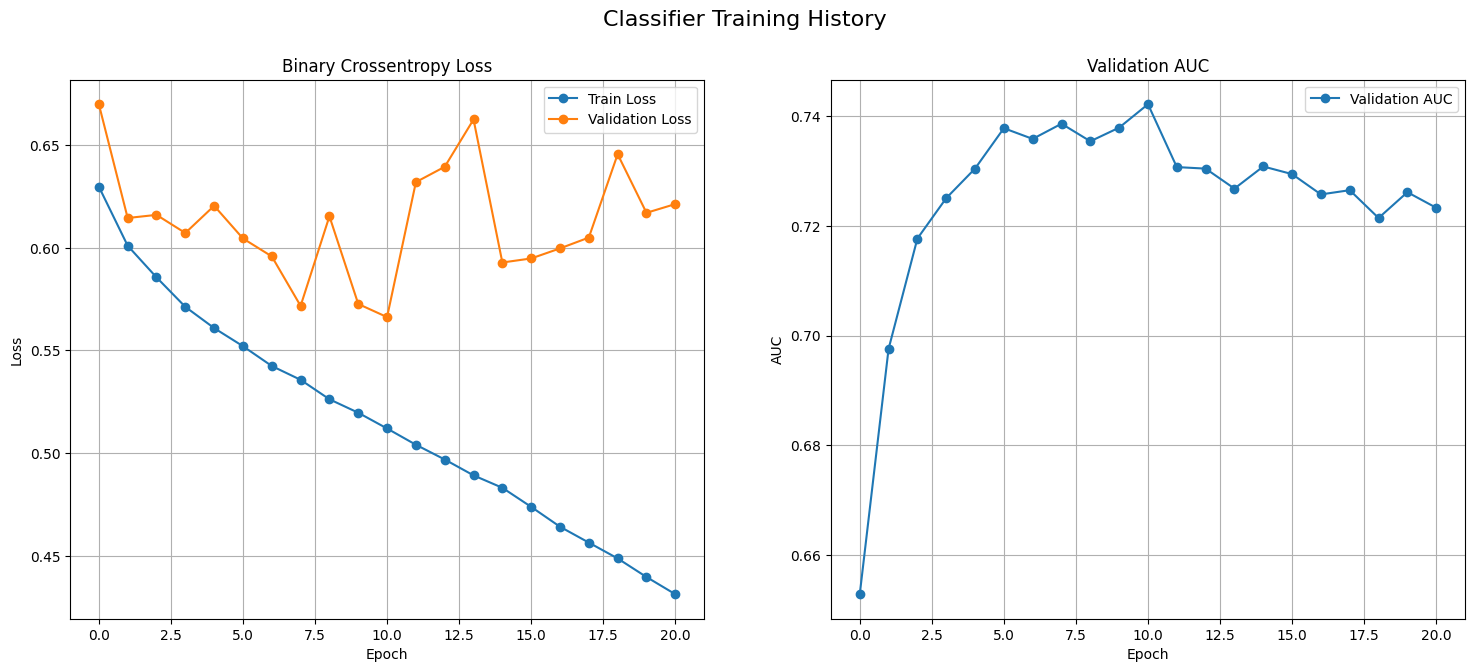

In [ ]:
from sklearn.metrics import multilabel_confusion_matrix, precision_recall_curve, average_precision_score
import itertools

print("\n--- Evaluating Model on the Test Set ---")
y_pred_probs = model.predict(test_dataset)
y_pred_binary = (y_pred_probs > THRESHOLD).astype(int)

num_predictions = len(y_pred_binary)
y_test_eval = y_test[:num_predictions]

print("\n--- Classification Report (5 Stuttering Classes) ---")
report = classification_report(y_test_eval, y_pred_binary, target_names=LABEL_COLS, zero_division=0)
print(report)
with open(OUTPUT_DIR / "classification_report.txt", "w") as f:
    f.write(report)

print("\n--- Generating plots for model training history... ---")
history_dict = history.history
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(18, 7))
fig.suptitle('Classifier Training History', fontsize=16)
ax1.plot(history_dict['loss'], 'o-', label='Train Loss')
ax1.plot(history_dict['val_loss'], 'o-', label='Validation Loss')
ax1.set_title('Binary Crossentropy Loss'); ax1.set_xlabel('Epoch'); ax1.set_ylabel('Loss'); ax1.legend(); ax1.grid(True)
ax2.plot(history_dict['val_auc'], 'o-', label='Validation AUC')
ax2.set_title('Validation AUC'); ax2.set_xlabel('Epoch'); ax2.set_ylabel('AUC'); ax2.legend(); ax2.grid(True)
plt.savefig(OUTPUT_DIR / "training_history.png")
plt.show()


--- Evaluating Model on the Test Set ---


I0000 00:00:1753437292.334253      10 encapsulate_tpu_computations_pass.cc:266] Subgraph fingerprint:13792096347998323035
E0000 00:00:1753437292.377121      10 meta_optimizer.cc:966] model_pruner failed: INVALID_ARGUMENT: Graph does not contain terminal node functional_2_1/batch_normalization_4_1/Cast/ReadVariableOp.
I0000 00:00:1753437292.494160    1018 tpu_compilation_cache_interface.cc:442] TPU host compilation cache miss: cache_key(13080087114780918747), session_name()
I0000 00:00:1753437293.870065    1018 tpu_compile_op_common.cc:245] Compilation of 13080087114780918747 with session name  took 1.375854881s and succeeded
I0000 00:00:1753437293.874760    1018 tpu_compilation_cache_interface.cc:476] TPU host compilation cache: compilation complete for cache_key(13080087114780918747), session_name(), subgraph_key(std::string(property.function_name) = "cluster_one_step_on_data_distributed_13792096347998323035", property.function_library_fingerprint = 8452913406505037254, property.mlir_

54/55 ━━━━━━━━━━━━━━━━━━━━ 0s 88ms/step

I0000 00:00:1753437299.291642      10 encapsulate_tpu_computations_pass.cc:266] Subgraph fingerprint:8328774366022966589
I0000 00:00:1753437299.501425    1005 tpu_compilation_cache_interface.cc:442] TPU host compilation cache miss: cache_key(7350295197032891225), session_name()
I0000 00:00:1753437301.573901    1005 tpu_compile_op_common.cc:245] Compilation of 7350295197032891225 with session name  took 2.072428056s and succeeded
I0000 00:00:1753437301.578940    1005 tpu_compilation_cache_interface.cc:476] TPU host compilation cache: compilation complete for cache_key(7350295197032891225), session_name(), subgraph_key(std::string(property.function_name) = "cluster_one_step_on_data_distributed_8328774366022966589", property.function_library_fingerprint = 3415727921461916589, property.mlir_module_fingerprint = 0, property.num_replicas = 8, topology.chip_bounds().x = 2, topology.chip_bounds().y = 2, topology.chip_bounds().z = 1, topology.wrap().x = false, topology.wrap().y = false, topolog

55/55 ━━━━━━━━━━━━━━━━━━━━ 17s 207ms/step

--- Classification Report (5 Stuttering Classes) ---
              precision    recall  f1-score   support

Prolongation       0.67      0.44      0.53      2613
       Block       0.62      0.40      0.49      3501
    SoundRep       0.62      0.42      0.50      1891
     WordRep       0.49      0.51      0.50      1742
Interjection       0.86      0.64      0.73      3344

   micro avg       0.67      0.49      0.56     13091
   macro avg       0.65      0.48      0.55     13091
weighted avg       0.67      0.49      0.56     13091
 samples avg       0.60      0.51      0.52     13091


--- Generating plots for model training history... ---


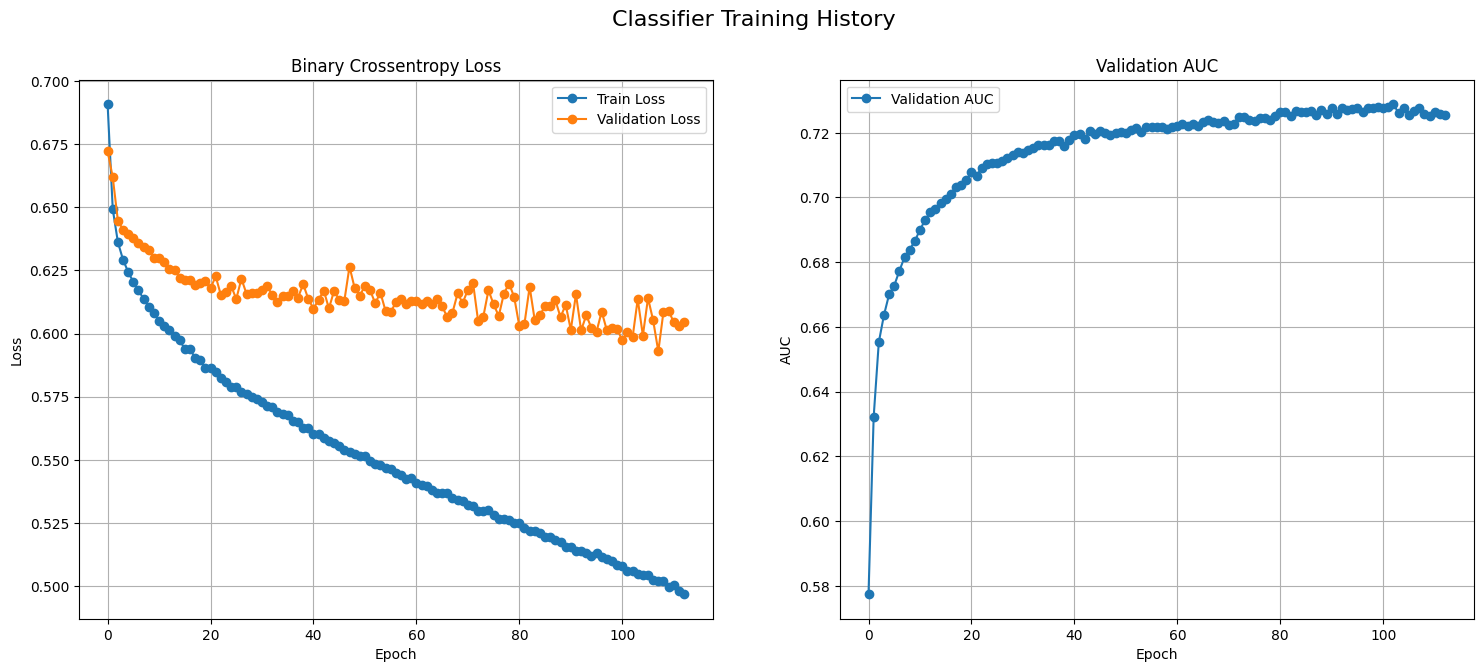

In [ ]:
from sklearn.metrics import multilabel_confusion_matrix, precision_recall_curve, average_precision_score
import itertools

print("\n--- Evaluating Model on the Test Set ---")
y_pred_probs = model.predict(test_dataset)
y_pred_binary = (y_pred_probs > THRESHOLD).astype(int)

num_predictions = len(y_pred_binary)
y_test_eval = y_test[:num_predictions]

print("\n--- Classification Report (5 Stuttering Classes) ---")
report = classification_report(y_test_eval, y_pred_binary, target_names=LABEL_COLS, zero_division=0)
print(report)
with open(OUTPUT_DIR / "classification_report.txt", "w") as f:
    f.write(report)

print("\n--- Generating plots for model training history... ---")
history_dict = history.history
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(18, 7))
fig.suptitle('Classifier Training History', fontsize=16)
ax1.plot(history_dict['loss'], 'o-', label='Train Loss')
ax1.plot(history_dict['val_loss'], 'o-', label='Validation Loss')
ax1.set_title('Binary Crossentropy Loss'); ax1.set_xlabel('Epoch'); ax1.set_ylabel('Loss'); ax1.legend(); ax1.grid(True)
ax2.plot(history_dict['val_auc'], 'o-', label='Validation AUC')
ax2.set_title('Validation AUC'); ax2.set_xlabel('Epoch'); ax2.set_ylabel('AUC'); ax2.legend(); ax2.grid(True)
plt.savefig(OUTPUT_DIR / "training_history.png")
plt.show()